In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf

In [3]:
np.set_printoptions(suppress=True)

RNG = np.random.default_rng(1069)

In [4]:
N_OBS = 4000
(DISP_X, DISP_Y) = (2560, 1080)
PARAM_NAMES = [r"$\mu$", r"$\sigma$"]

Brute-force simulation to make sure that this is not stupid.

<Axes: >

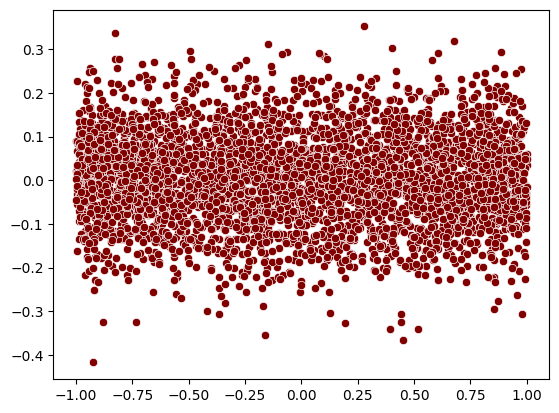

In [5]:
y = RNG.normal(0., 0.1, size=N_OBS)
x = RNG.uniform(-1., 1., size=N_OBS)

sns.scatterplot(x=x, y=y, color='maroon')

Properly-defined prior and simulator for BayesFlow.

In [6]:
def prior_fun(rng=None):
    """
    Generate prior parameters for vertical gaze distribution.
    """
    if rng is None:
        rng = np.random.default_rng()

    mu = rng.normal(0, 1)
    sigma = rng.gamma(2, 2)

    theta = np.array([mu, sigma])

    return theta

In [48]:
def gaze_simulator_fun(theta, N_OBS=1000, rng=None):

    mu, sigma = theta

    if rng is None:
        rng = np.random.default_rng()


    x = rng.uniform(-1., 1., size=N_OBS)
    y = rng.normal(mu, sigma, size=N_OBS)

    gaze_xy = np.array([x, y])
    return gaze_xy

Again simulating in brute force.

<Axes: >

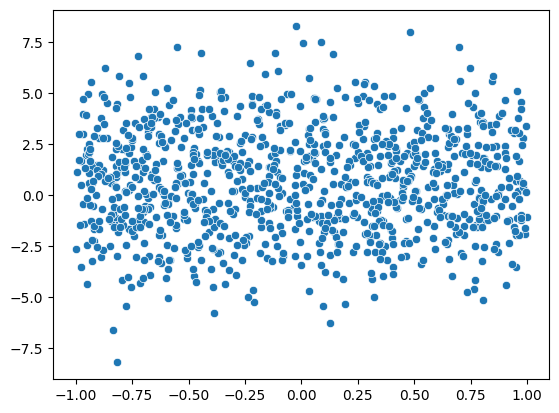

In [49]:
theta = prior_fun()
gaze_xy = gaze_simulator_fun(theta, N_OBS=1000)

sns.scatterplot(x=gaze_xy[0], y=gaze_xy[1])

Wrapping them up with `bf.simulation`.

In [50]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)

Prior predictive check

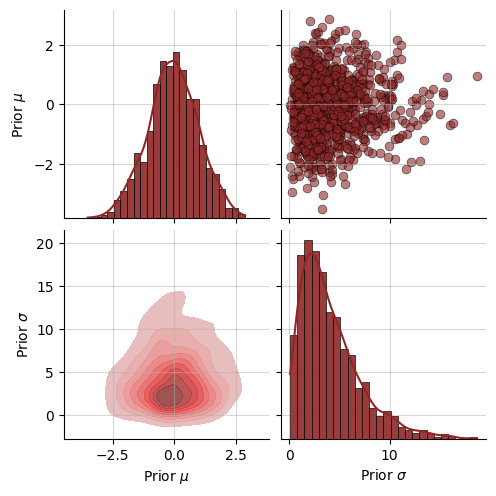

In [51]:
# Prior predictive check
f = bf.diagnostics.plot_prior2d(prior=prior, n_samples=1000, param_names=PARAM_NAMES)

### Generative Model

In [52]:
model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=gaze_simulator_fun,
    name="gaze",
    simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the gaze model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 1000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [53]:
sim = model(100)

In [54]:
sim

{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[-0.73447911,  0.79705463],
        [ 0.88687488,  3.92561432],
        [ 1.26607045,  3.4001293 ],
        [-0.7128532 ,  1.42611127],
        [ 1.03775843,  1.64289696],
        [ 1.05659983, 13.17849972],
        [-0.33716475,  4.07962853],
        [-1.31785159,  1.61641375],
        [ 1.57355059,  8.0840873 ],
        [ 0.00607446,  5.26389973],
        [-0.43220334,  2.31074914],
        [ 0.0414755 ,  7.42497837],
        [-0.6724768 ,  7.98988368],
        [ 1.55786679,  5.71271689],
        [ 0.37295497,  1.95397416],
        [ 0.46896878,  2.51567617],
        [-0.1818238 ,  4.20749494],
        [ 0.7124695 ,  3.89701502],
        [ 1.3081464 ,  9.34549993],
        [-0.73741888,  3.50188413],
        [-1.54876101,  9.7429132 ],
        [ 0.4834599 ,  5.35319438],
        [-0.71296732,  0.83516049],
        [ 0.77206569,  1.38831041],
        [-0.08577672,  3.36963999],
        [ 0.4

### Neural Approximator

In [56]:
summary_net = bf.summary_networks.DeepSet()

In [57]:
inference_net = bf.inference_networks.InvertibleNetwork(num_params=len(PARAM_NAMES))

In [58]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [59]:
def configurator(forward_dict):
    out_dict = {}

    out_dict["parameters"] = forward_dict["prior_draws"]
    out_dict["summary_conditions"] = forward_dict["sim_data"]

    return out_dict

In [60]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [61]:
amortizer.summary()

Model: "amortized_posterior_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_1 (Inve  multiple                  436296    
 rtibleNetwork)                                                  
                                                                 
 deep_set_1 (DeepSet)        multiple                  195210    
                                                                 
Total params: 631506 (2.41 MB)
Trainable params: 631482 (2.41 MB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [62]:
losses = trainer.train_online(epochs=10, iterations_per_epoch=100, batch_size=32)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

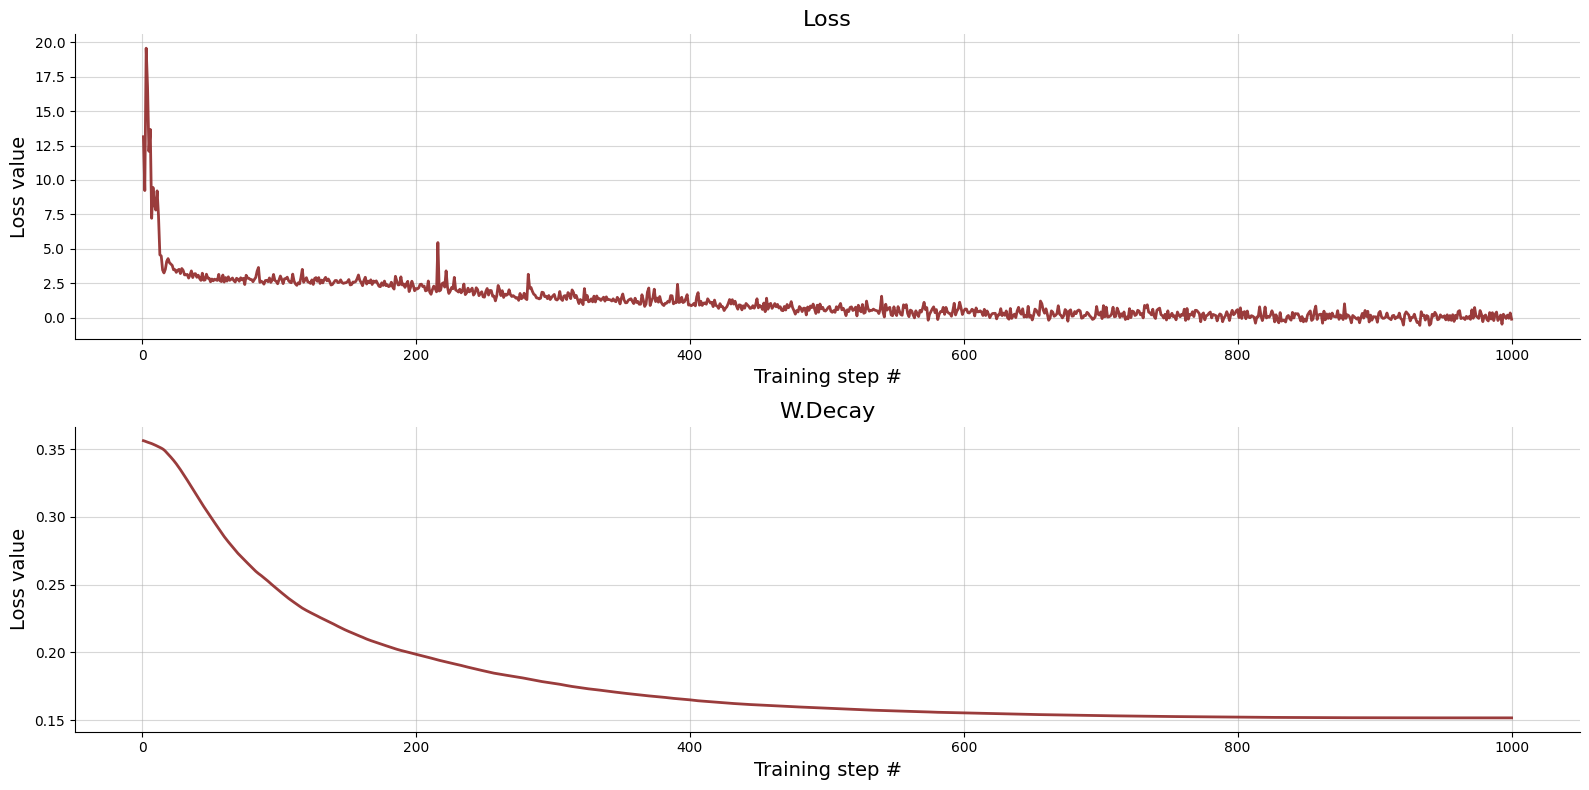

In [63]:
f = bf.diagnostics.plot_losses(losses)

<Axes: >

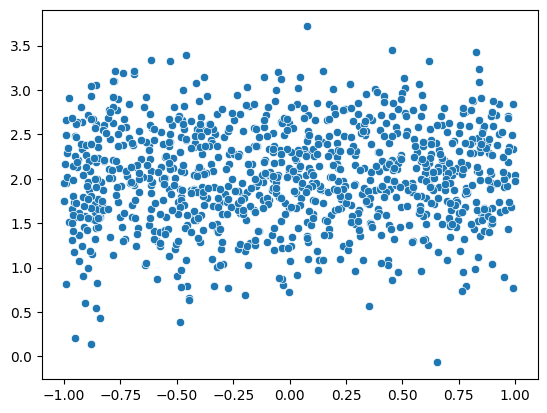

In [64]:
## Parameter recovery
resim = configurator(model(500))
resim['summary_conditions'].shape
s = resim['summary_conditions'][0]
sns.scatterplot(x=s[0], y=s[1])

In [65]:
post_samples = amortizer.sample(resim, n_samples=1000)
post_samples.shape

(500, 1000, 2)

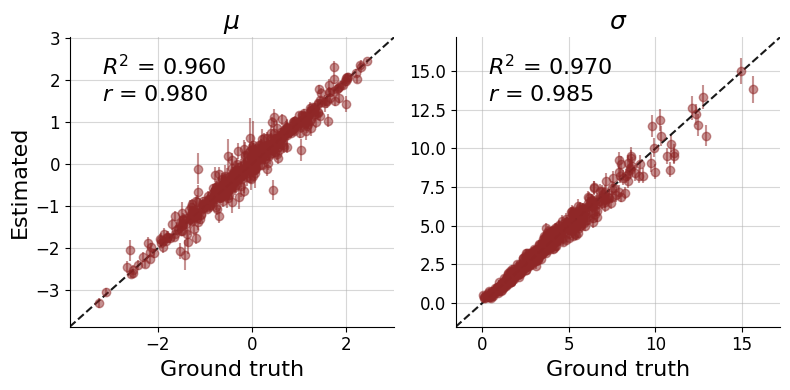

In [66]:
f = bf.diagnostics.plot_recovery(post_samples, resim['parameters'], param_names=PARAM_NAMES)

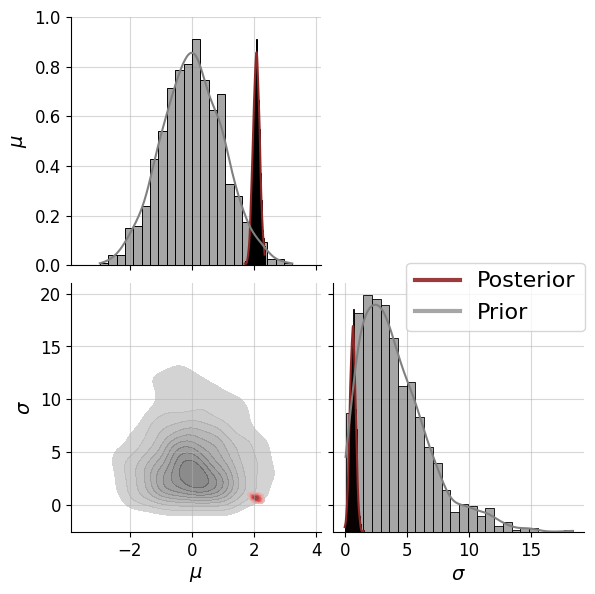

In [67]:
f = bf.diagnostics.plot_posterior_2d(post_samples[0], prior=prior)

<Axes: >

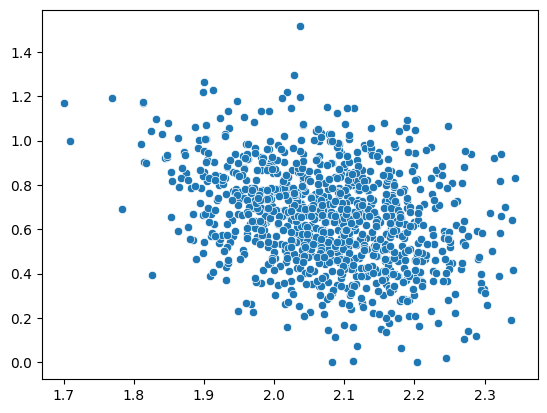

In [68]:
samples = post_samples[0]
sns.scatterplot(x=samples[:,0], y=samples[:,1])